In [2]:
import sys
sys.path.append('..')
from scripts.data_analysis import DataAnalysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
original_df = pd.read_csv('../data/data_wave1.csv')

In [4]:
columns_to_extract = [
    'aApoB', 'aHDL_C', 'aTotFA', 'aSerum_TG', 'aGp', 'aIle', 'Sexe', 'Age',
    'aauditsc', 'aedu', 'AIPMETO2', 'asmokstat', 'acidep09', 'ahsCRP', 'aIL6',
    'aIRSsum9', 'ams_waist', 'ams_hpt', 'ams_trig2', 'ams_hdl2', 'ams_gluc2',
    'amet_syn2', 'atri_med', 'ahdl_med', 'asbp_med', 'adbp_med', 'agluc_med'
]

extracted_df = original_df[columns_to_extract]

extracted_csv_file = '../data/wave1_data_to_discretize.csv'
extracted_df.to_csv(extracted_csv_file, index=False)

In [5]:
def classify_data(df):
    """
    Classify each column in a pandas DataFrame as continuous, discrete, binary, or categorical.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to classify.

    Returns:
    dict: A dictionary with column names as keys and their classifications as values.
    """
    def classify_series(series):
        """
        Classify a pandas Series as continuous, discrete, binary, or categorical.
        
        Parameters:
        series (pd.Series): The Series from a column to classify.

        Returns:
        str: The classification of the series ('continuous', 'discrete', 'binary', 'categorical').
        """
        if pd.api.types.is_numeric_dtype(series):
            unique_count = series.nunique()
            total_count = len(series)
            
            if unique_count == 2:
                return 'binary'
            elif unique_count / total_count < 0.05:
                return 'discrete'
            else:
                return 'continuous'
        else:
            return 'categorical'

    column_classifications = {col: classify_series(df[col]) for col in df.columns}
    return column_classifications

In [6]:
data = pd.read_csv('../data/wave1_data_to_discretize.csv')

In [7]:
# replace -1 in amet_syn2 with NaN
data['amet_syn2'] = data['amet_syn2'].replace(-1, np.nan).astype('Int64')
data['amet_syn2'].unique()

<IntegerArray>
[0, 1, <NA>]
Length: 3, dtype: Int64

In [8]:
classify_data(data)

{'aApoB': 'continuous',
 'aHDL_C': 'continuous',
 'aTotFA': 'continuous',
 'aSerum_TG': 'continuous',
 'aGp': 'continuous',
 'aIle': 'continuous',
 'Sexe': 'binary',
 'Age': 'discrete',
 'aauditsc': 'discrete',
 'aedu': 'discrete',
 'AIPMETO2': 'continuous',
 'asmokstat': 'discrete',
 'acidep09': 'binary',
 'ahsCRP': 'continuous',
 'aIL6': 'continuous',
 'aIRSsum9': 'discrete',
 'ams_waist': 'discrete',
 'ams_hpt': 'discrete',
 'ams_trig2': 'discrete',
 'ams_hdl2': 'discrete',
 'ams_gluc2': 'discrete',
 'amet_syn2': 'binary',
 'atri_med': 'continuous',
 'ahdl_med': 'continuous',
 'asbp_med': 'continuous',
 'adbp_med': 'discrete',
 'agluc_med': 'discrete'}

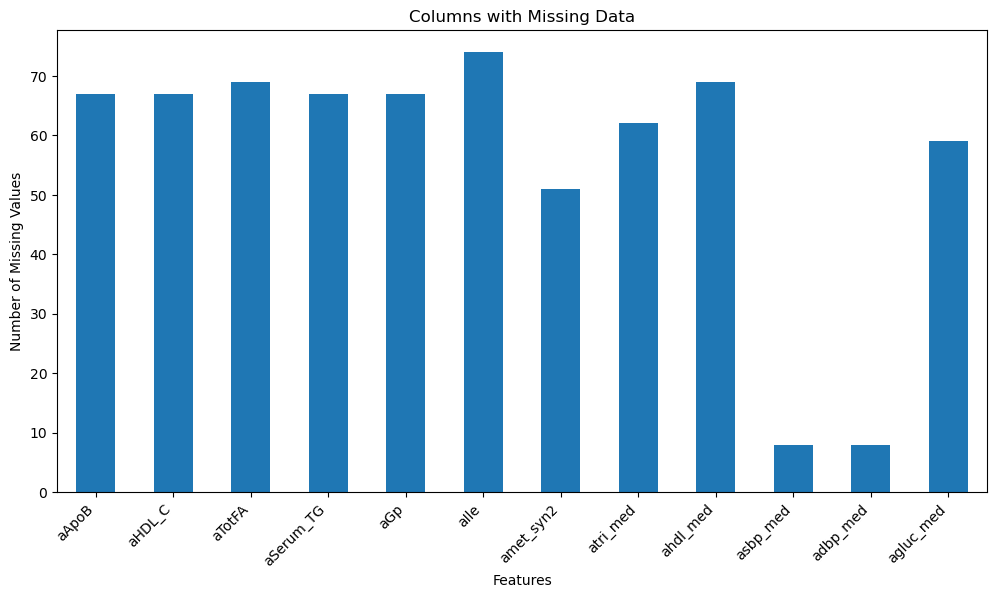

In [9]:
DataAnalysis.plot_missing_values(data)

In [15]:
from scipy.stats import chi2_contingency

def perform_little_mcar_test(df):
    results = []

    for col_with_missing_data in df.columns[df.isnull().any()]:
        # Create a mask indicating where data is missing
        missing_data = df[col_with_missing_data ].isnull().astype(int)

        # Create contingency table for Chi-Squared test
        contingency_table = pd.crosstab(missing_data, df.drop(columns=[col_with_missing_data]).isnull().any(axis=1).astype(int))

        # Perform Chi-Squared test
        chi2_stat, p_val, dof, _ = chi2_contingency(contingency_table, correction=False)

        # Append results
        results.append({'Column': col_with_missing_data, 'Chi-Squared': chi2_stat, 'df': dof, 'p-value': p_val})

    return pd.DataFrame(results)

perform_little_mcar_test(data)

,Column,Chi-Squared,df,p-value
0,aApoB,1293.587593,1,2.797243e-283
1,aHDL_C,1293.587593,1,2.797243e-283
2,aTotFA,1270.867883,1,2.421556e-278
3,aSerum_TG,1293.587593,1,2.797243e-283
4,aGp,1293.587593,1,2.797243e-283
5,aIle,1221.592975,1,1.237593e-267
6,amet_syn2,912.950279,1,1.501785e-200
7,atri_med,1068.321477,1,2.535843e-234
8,ahdl_med,972.852995,1,1.429313e-213
9,asbp_med,151.392954,1,8.600073e-35


Data is not missing completely at random so we cannot discard it

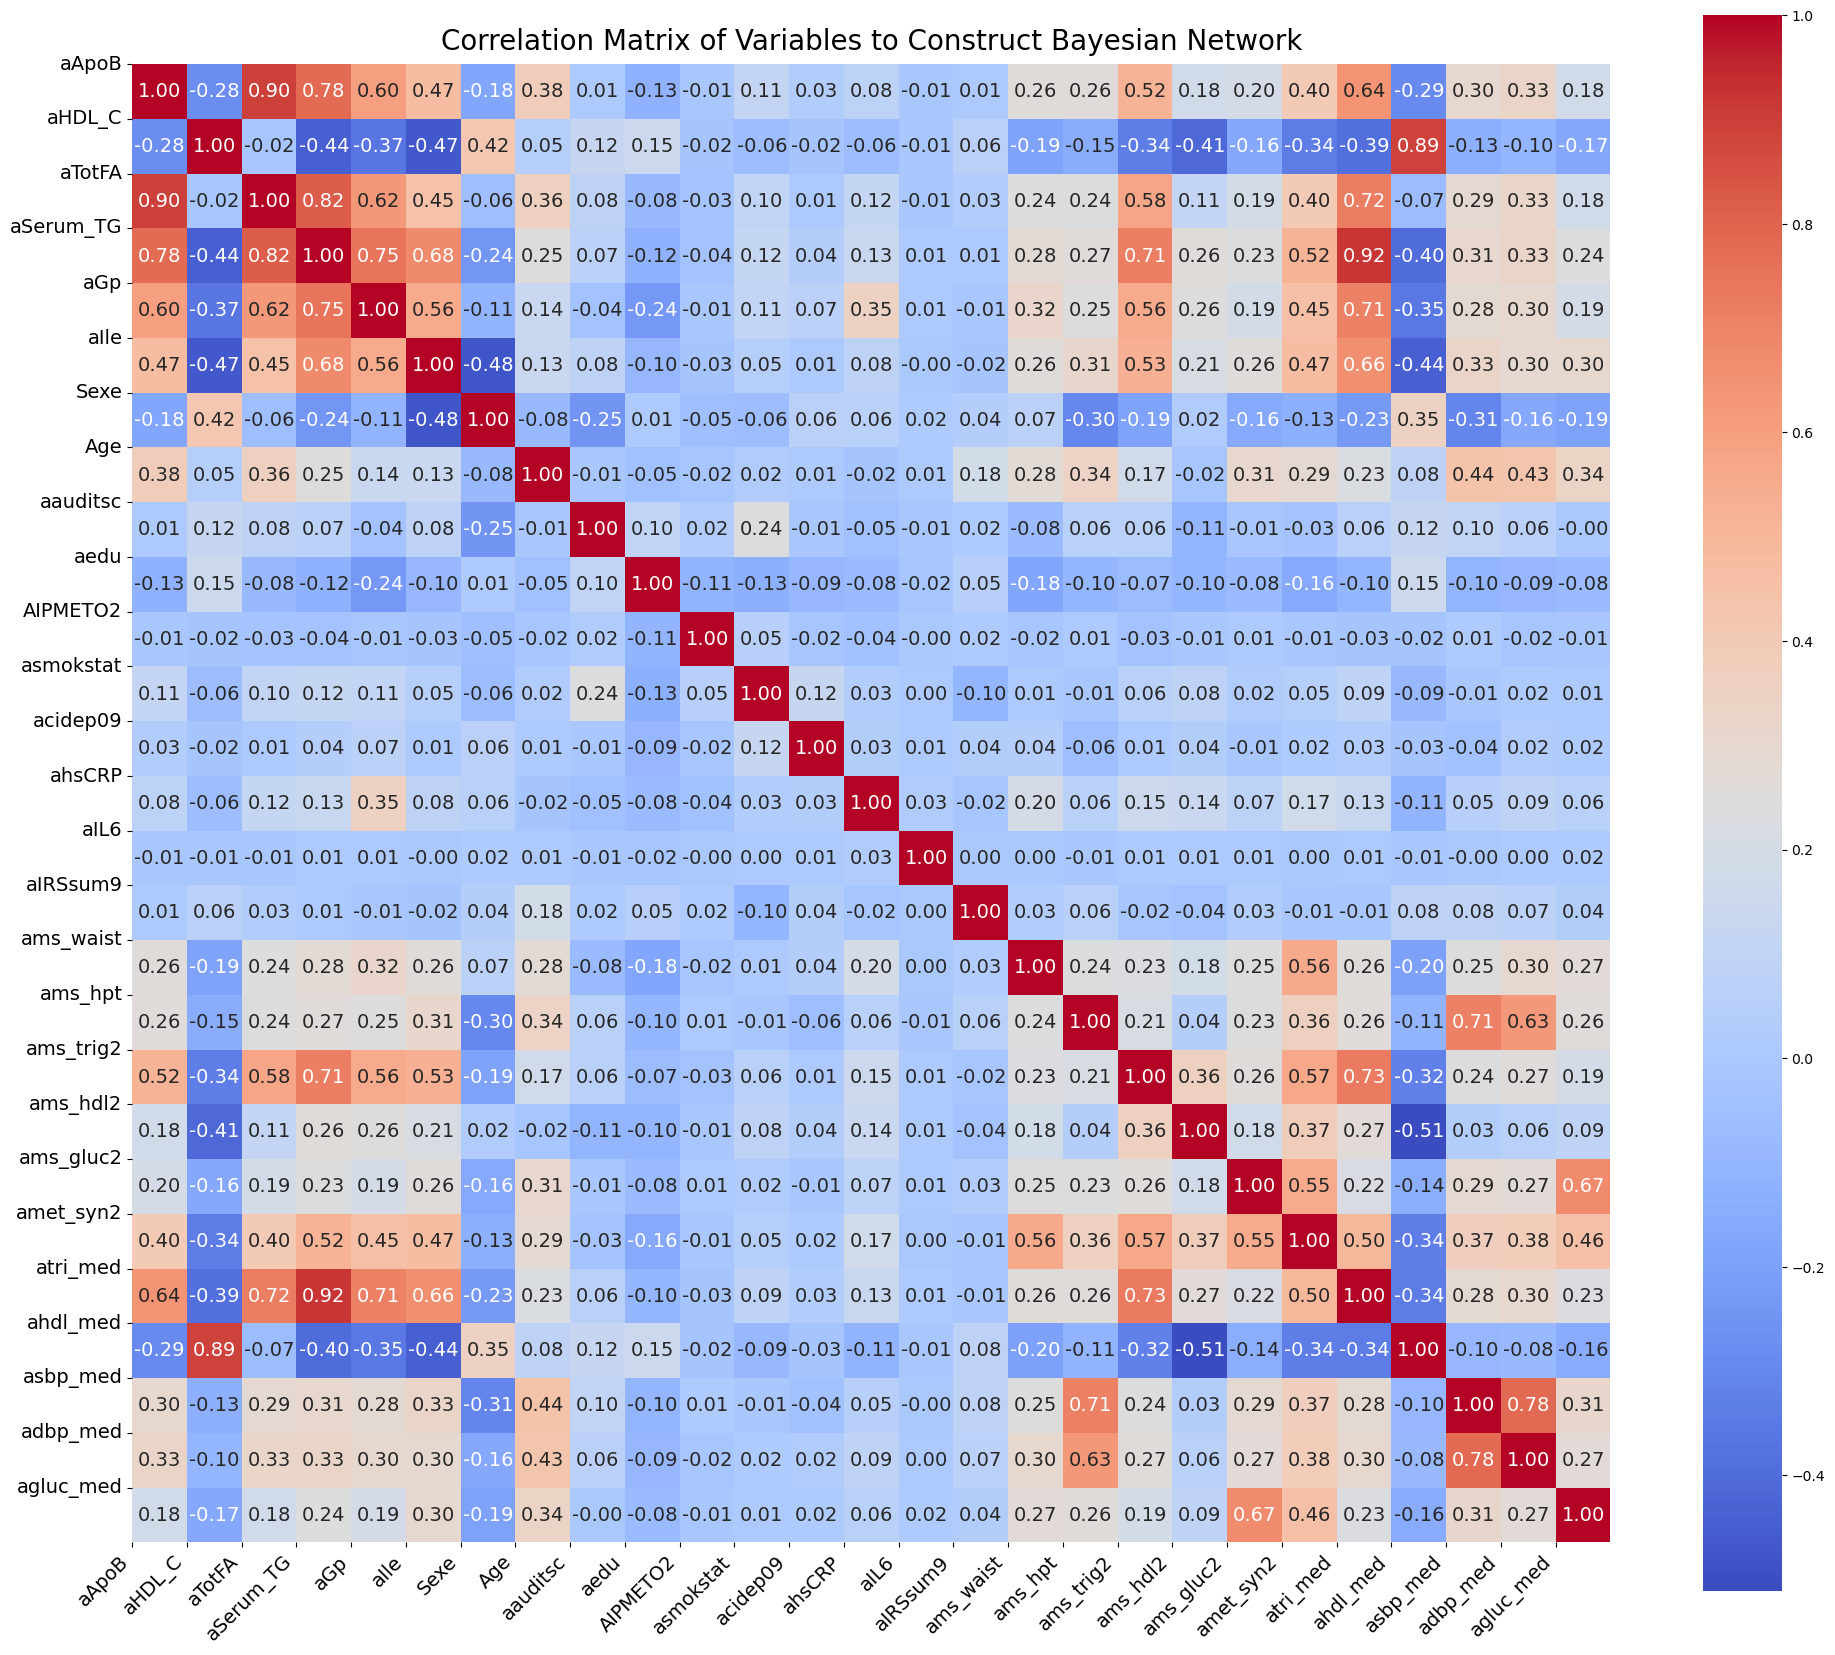

In [14]:
DataAnalysis.plot_correlation_matrix(data, columns_to_extract, 'Variables to Construct Bayesian Network')

Now, we are going to determine the imputation strategy for each column with missing data based on correlation matrix

In [28]:
corr_matrix = data.corr().abs()


In [26]:
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer

def impute_missing_values(df, corr_matrix):
    imputed_df = df.copy()

    if 'amet_syn2' in df.columns:
        correlated_vars = ['ams_trig2', 'ams_hdl2', 'ams_hpt', 'ams_gluc2', 'atri_med', 'ahdl_med', 'asbp_med', 'adbp_med', 'agluc_med']
        imputation_vars = ['amet_syn2'] + correlated_vars
        data_for_imputation = df[imputation_vars]
        
        iter_imputer = IterativeImputer(max_iter=100, random_state=42)
        imputed_data = iter_imputer.fit_transform(data_for_imputation)
        # convert to binary
        imputed_df['amet_syn2'] = np.round(imputed_data[:, 0]).astype(int)

    for col in df.columns[df.isnull().any()]:
        if col == 'amet_syn2':
            continue

        col_corr = corr_matrix[col].drop(col)
        max_corr = col_corr.max()

        # use MICE for highly correlated columns
        if max_corr > 0.8:
            mice_imputer = IterativeImputer(random_state=42)
            imputed_df[col] = mice_imputer.fit_transform(df[[col] + col_corr.index.tolist()])[:, 0]
        # use kNN for moderately correlated columns
        elif max_corr > 0.3:
            knn_imputer = KNNImputer(n_neighbors=10)
            imputed_df[col] = knn_imputer.fit_transform(df[[col] + col_corr.index.tolist()])[:, 0]

    return imputed_df

In [29]:
imputed_df = impute_missing_values(data, corr_matrix)

In [34]:
DataAnalysis.plot_missing_values(imputed_df)

No missing values
